In [13]:
from adult import AdultRaw
import dill
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import cross_val_score
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from tqdm import tqdm

from probspecs import (
    MultidimensionalIndependent,
    ContinuousDistribution1d,
    TensorInputSpace,
)
from probspecs.population_models import FactorAnalysisModel, EncodeOneHot

from input_spaces import adult_input_space

torch.manual_seed(353710130163567)
np.random.seed(2548400)

In [6]:
dataset = AdultRaw(
    root="../../.datasets", sensitive_attributes=("sex", "race"), download=True
)
X = dataset.data
mean = X.mean(dim=0)
std = X.std(dim=0)

X = (X - mean) / std

# Dataset Overview

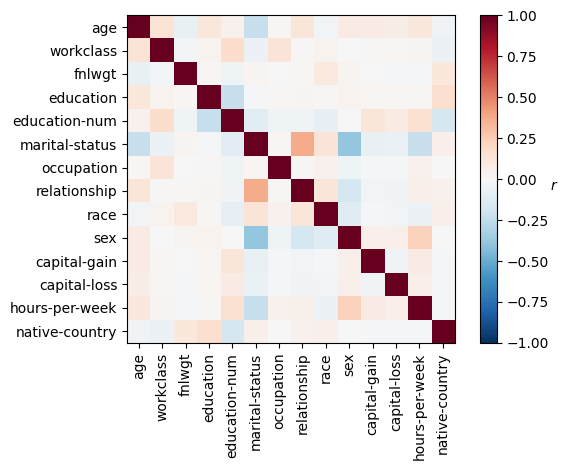

In [7]:
ax = plt.axes()
im = ax.imshow(torch.corrcoef(X.T), vmin=-1.0, vmax=1.0, cmap="RdBu_r")
ax.set_xticks(np.arange(len(dataset.columns)))
ax.set_xticklabels(dataset.columns, rotation=90)
ax.set_yticks(np.arange(len(dataset.columns)))
ax.set_yticklabels(dataset.columns)

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
plt.tight_layout()

# PCA

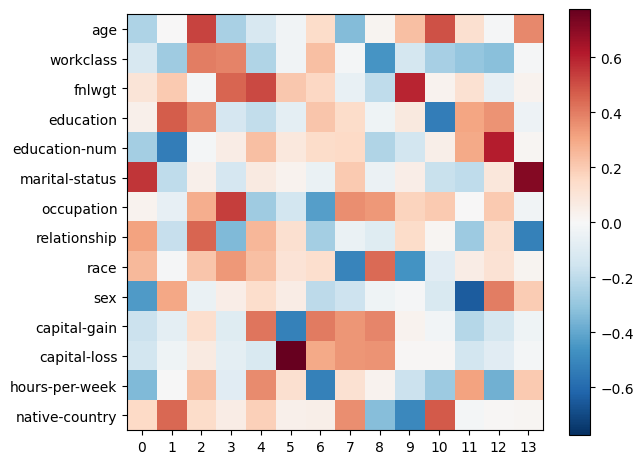

In [8]:
n_components = None
pca = PCA(n_components)
pca.fit(X)
components = pca.components_.T

ax = plt.axes()
vmax = np.abs(components).max()
im = ax.imshow(components, vmax=vmax, vmin=-vmax, cmap="RdBu_r")
ax.set_yticks(np.arange(len(dataset.columns)))
ax.set_yticklabels(dataset.columns)
ax.set_xticks(np.arange(components.shape[1]))

plt.colorbar(im)
plt.tight_layout()

# Factor Analysis

In [76]:
factor_analysis = FactorAnalysis(rotation="varimax", random_state=5154633)
scores = []
for n_components in tqdm(range(len(dataset.columns))):
    factor_analysis.n_components = n_components
    score = np.mean(cross_val_score(factor_analysis, X))
    scores.append(score)

plt.plot(np.arange(len(dataset.columns)), scores)

  7%|▋         | 1/14 [00:04<01:02,  4.82s/it]


KeyboardInterrupt: 

-19.46839744863011


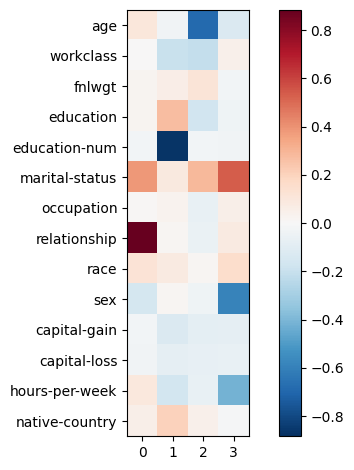

In [9]:
n_components = 4
factor_analysis = FactorAnalysis(n_components, rotation="varimax", random_state=5154633)
factor_analysis.fit(X)
components = factor_analysis.components_.T

ax = plt.axes()
vmax = np.abs(components).max()
im = ax.imshow(components, vmax=vmax, vmin=-vmax, cmap="RdBu_r")
ax.set_yticks(np.arange(len(dataset.columns)))
ax.set_yticklabels(dataset.columns)
ax.set_xticks(np.arange(components.shape[1]))

plt.colorbar(im)
plt.tight_layout()
print(factor_analysis.score(X))

# Build Population Model
Based on Factor Analysis: The factors are uncorrelated jointly normally distributed with mean zero, zero covariance and variance 1.
Similarly, the noise terms are jointly normally distributed with zero mean, zero covariance and certain fixed variances.
Since the factors and noise terms are jointly normally distributed and uncorrelated, they are independent.

In [10]:
W = factor_analysis.components_
W

array([[ 1.02867721e-01,  8.69680330e-04,  2.73864986e-02,
         2.69643349e-02, -2.13385937e-02,  3.85837451e-01,
         6.97177226e-03,  8.83516946e-01,  1.23301774e-01,
        -1.52737119e-01, -2.17263527e-02, -3.13971361e-02,
         9.37048993e-02,  5.45118337e-02],
       [-2.89949332e-02, -1.93292579e-01,  5.98555147e-02,
         2.75786920e-01, -8.64823625e-01,  8.40328354e-02,
         3.37845475e-02,  1.46828806e-02,  8.14180769e-02,
         1.90155564e-02, -1.30033548e-01, -8.15993817e-02,
        -1.59073577e-01,  2.02141940e-01],
       [-6.89355093e-01, -2.12369966e-01,  1.11336470e-01,
        -1.65872802e-01, -2.36479921e-02,  2.84199762e-01,
        -6.82551225e-02, -5.94147081e-02,  1.72563527e-02,
        -3.61439145e-02, -8.69175347e-02, -7.14529026e-02,
        -6.87600254e-02,  4.70975732e-02],
       [-1.24460790e-01,  4.20120440e-02, -2.54056033e-02,
        -4.06002030e-02, -3.23795206e-02,  5.33865202e-01,
         5.40021515e-02,  7.88610154e-02,  1.

In [11]:
eps_var = factor_analysis.noise_variance_
np.atleast_2d(eps_var)

array([[0.49777753, 0.91574525, 0.98259261, 0.89401638, 0.25003991,
        0.478232  , 0.99120523, 0.20956063, 0.95441242, 0.62442246,
        0.96874377, 0.9826305 , 0.78506219, 0.95376573]])

In [12]:
# Truncate normal distributions after four standard deviations.
# Covers >0.9999 of the probability mass of a regular normal distribution.
ran = 4.0
factor_distributions = [
    ContinuousDistribution1d(truncnorm(a=-ran, b=ran, loc=0.0, scale=1.0))
    for _ in range(W.shape[0])
]
noise_std = np.sqrt(eps_var)
noise_distributions = [
    ContinuousDistribution1d(truncnorm(a=-ran * std, b=ran * std, loc=0.0, scale=std))
    for std in noise_std
]
distribution = MultidimensionalIndependent(
    *(factor_distributions + noise_distributions),
    input_shape=(W.shape[0] + eps_var.shape[0])
)

input_space = TensorInputSpace(
    lbs=torch.tensor([-ran] * W.shape[0] + (-ran * noise_std).tolist()),
    ubs=torch.tensor([-ran] * W.shape[0] + (ran * noise_std).tolist()),
)

from_factors_and_noise = FactorAnalysisModel(factor_loadings=torch.as_tensor(W).T)
encode_one_hot = EncodeOneHot(
    [
        None if isinstance(values, int) else len(values)
        for values in adult_input_space.encoding_layout.values()
    ]
)
population_model = nn.Sequential(from_factors_and_noise, encode_one_hot)

In [17]:
with open("../../resources/adult/factor_analysis_distribution.dill", "wb") as file:
    dill.dump(distribution, file)
with open("../../resources/adult/factor_analysis_input_space.dill", "wb") as file:
    dill.dump(input_space, file)
torch.save(
    population_model, "../../resources/adult/factor_analysis_population_model.pyt"
)